# **Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import gensim
from gensim.models import Word2Vec
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

# Data Exploration

In [ ]:
df_training=pd.read_csv("/content/twitter_training.csv")
df_validation=pd.read_csv("/content/twitter_validation.csv")


In [ ]:
df_training.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
df_validation.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [ ]:
df_training.columns=['id','company','sentiment','text']
df_validation.columns=['id','company','sentiment','text']

In [ ]:
df_training.head()
df_training['sentiment'] = df_training['sentiment'][df_training['sentiment'] != 'Irrelevant']

# Visulization Part

In [ ]:
company_counts=df_training['company'].value_counts()
semtiment_counts=df_training['sentiment'].value_counts()

In [ ]:
def visulization_bar_chart(df,column):
  counts=df[column].value_counts()
  fig=px.bar(x=counts.index,y=counts.values)
  fig.update_layout(
      title=f"Distribution of {column}",
      xaxis_title=column,
      yaxis_title="Count"
  )
  fig.show()
def makePieChart(df,column):
  counts=df[column].value_counts()
  fig=px.pie(names=counts.index,values=counts.values)
  fig.update_layout(
      title=f"Distribution of {column}",
      xaxis_title=column,
      yaxis_title="Count"
  )
  fig.show()
visulization_bar_chart(df_training,'company')
visulization_bar_chart(df_training,'sentiment')
makePieChart(df_training,'company')
makePieChart(df_training,'sentiment')

In [ ]:
df=df_training.copy()

In [ ]:
def makeWordCloud(df):
  text=' '.join(df['preprocessed_text'].astype(str))
  wordcloud=WordCloud(width=800,height=800,background_color='white').generate(text)
  plt.figure(figsize=(8,8))
  plt.imshow(wordcloud,interpolation='bilinear')
  plt.axis('off')


# Preprocessing Part

In [ ]:
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

In [ ]:
####### main
df['preprocessed_text']=df['text'].apply(preprocess)

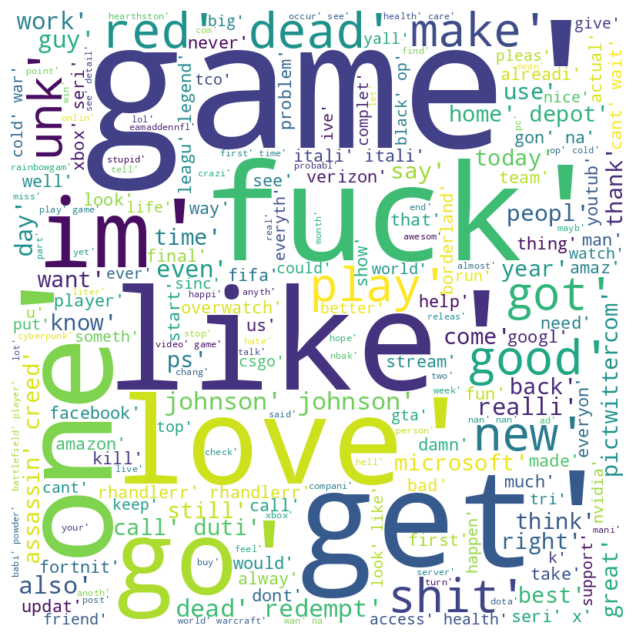

In [ ]:
makeWordCloud(df)

In [ ]:
df.head()

,id,company,sentiment,text,preprocessed_text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,"[come, border, kill]"
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,"[im, get, borderland, kill]"
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,"[im, come, borderland, murder]"
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,"[im, get, borderland, murder]"
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,"[im, get, borderland, murder]"


In [ ]:
df=df[['preprocessed_text','sentiment']]

In [ ]:
df.head()

,preprocessed_text,sentiment
0,"[come, border, kill]",Positive
1,"[im, get, borderland, kill]",Positive
2,"[im, come, borderland, murder]",Positive
3,"[im, get, borderland, murder]",Positive
4,"[im, get, borderland, murder]",Positive


# Conversion of words to embeddings

In [ ]:
word2vec=Word2Vec(sentences=df['preprocessed_text'],vector_size=100,window=5,min_count=1,workers=4)
word2vec.save("word2vec_model.model")

In [5]:
def sentence_to_embedding(sentence,model):
  word_vectors=[model.wv[word] for word in sentence if word in model.wv]
  if not word_vectors:
    return np.zeros(model.vector_size)
  return np.mean(word_vectors,axis=0)

In [ ]:
df['embeddings']=df['preprocessed_text'].apply(lambda x:sentence_to_embedding(x,word2vec))

In [ ]:
df_validation['preprocessed_text']=df_validation['text'].apply(preprocess)
df_validation['embeddings']=df_validation['preprocessed_text'].apply(lambda x:sentence_to_embedding(x,word2vec))

In [ ]:
df

,preprocessed_text,sentiment,embeddings
0,"[come, border, kill]",Positive,"[0.7265325, -0.46211556, -0.22379363, 0.021703..."
1,"[im, get, borderland, kill]",Positive,"[0.32531485, -0.8008024, -0.47753465, -0.14326..."
2,"[im, come, borderland, murder]",Positive,"[0.7209515, -1.1470996, -0.2872638, -0.1256285..."
3,"[im, get, borderland, murder]",Positive,"[0.28030547, -0.9619984, -0.3318649, -0.088428..."
4,"[im, get, borderland, murder]",Positive,"[0.28030547, -0.9619984, -0.3318649, -0.088428..."
...,...,...,...
74676,"[realiz, window, partit, mac, like, year, behi...",Positive,"[-0.028883545, -0.35996214, -0.050440773, 0.13..."
74677,"[realiz, mac, window, partit, year, behind, nv...",Positive,"[0.046536542, -0.28046247, -0.053244445, 0.134..."
74678,"[realiz, window, partit, mac, year, behind, nv...",Positive,"[0.046536554, -0.28046247, -0.053244457, 0.134..."
74679,"[realiz, window, partit, mac, like, year, behi...",Positive,"[-0.11245464, -0.36382684, 0.023383936, 0.0127..."


In [ ]:
def most_similar_tweet(query,df):
  query_embedding=sentence_to_embedding(query,word2vec)
  df['similarity']=df['embeddings'].apply(lambda x:np.dot(x,query_embedding)/(np.linalg.norm(x)*np.linalg.norm(query_embedding)))

  index=df['similarity'].idxmax()
  print("Most Similar Tweet : ",df.iloc[index]['preprocessed_text'])

most_similar_tweet("i am happy bro what about you",df)

<ipython-input-23-d1d931f1532b>:3: RuntimeWarning:

invalid value encountered in scalar divide



Most Similar Tweet :  ['cyberpunkgam', 'r', 'b', 'plu', 'h', 'p', 'hell', 'eah']


In [ ]:
df

,preprocessed_text,sentiment,embeddings,similarity
0,"[come, border, kill]",Positive,"[0.7265325, -0.46211556, -0.22379363, 0.021703...",0.448319
1,"[im, get, borderland, kill]",Positive,"[0.32531485, -0.8008024, -0.47753465, -0.14326...",0.394198
2,"[im, come, borderland, murder]",Positive,"[0.7209515, -1.1470996, -0.2872638, -0.1256285...",0.461474
3,"[im, get, borderland, murder]",Positive,"[0.28030547, -0.9619984, -0.3318649, -0.088428...",0.447817
4,"[im, get, borderland, murder]",Positive,"[0.28030547, -0.9619984, -0.3318649, -0.088428...",0.447817
...,...,...,...,...
74676,"[realiz, window, partit, mac, like, year, behi...",Positive,"[-0.028883545, -0.35996214, -0.050440773, 0.13...",0.528439
74677,"[realiz, mac, window, partit, year, behind, nv...",Positive,"[0.046536542, -0.28046247, -0.053244445, 0.134...",0.533071
74678,"[realiz, window, partit, mac, year, behind, nv...",Positive,"[0.046536554, -0.28046247, -0.053244457, 0.134...",0.533071
74679,"[realiz, window, partit, mac, like, year, behi...",Positive,"[-0.11245464, -0.36382684, 0.023383936, 0.0127...",0.526307


# Models

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.preprocessing import LabelEncoder
sentiment_mapping = {
    'Positive': 1,
    'Negative': 2,
    'Neutral': 0

    # Add other sentiment mappings as needed
}
df_validation['encoded_sentiment'] = df_validation['sentiment'].map(sentiment_mapping)
df['encoded_sentiment'] = df['sentiment'].map(sentiment_mapping)

In [ ]:
df['sentiment'].unique()
df=df[df['sentiment']!='Irrelevant']
df_validation=df_validation[df_validation['sentiment']!='Irrelevant']

In [ ]:
df.isnull().sum()

,0
preprocessed_text,0
sentiment,12990
embeddings,0
similarity,1644
encoded_sentiment,12990


In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_model=LogisticRegression(max_iter=200)
df.dropna(inplace=True)
logistic_model.fit(df['embeddings'].tolist(),df['encoded_sentiment'])
y_pred=logistic_model.predict(df_validation['embeddings'].tolist())
accuracy=accuracy_score(df_validation['encoded_sentiment'],(y_pred))
print(accuracy)

0.6304347826086957


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Fit the Support Vector Machine (SVM) model on the training data
svm_model = SVC(kernel='linear')  # You can try different kernels like 'rbf' or 'poly'
svm_model.fit(df['embeddings'].tolist(), df['encoded_sentiment'])

# Predict on the validation set
y_pred_svm = svm_model.predict(df_validation['embeddings'].tolist())

# Calculate accuracy
accuracy_svm = accuracy_score(df_validation['encoded_sentiment'], y_pred_svm)

# Print the accuracy
print(f"SVM Accuracy: {accuracy_svm:.4f}")


KeyboardInterrupt: 

# RNN Model

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assume you already have the precomputed sentence embeddings and labels
X = np.array(df['embeddings'].tolist())  # X contains the sentence embeddings
y = np.array(df['encoded_sentiment'])  # y contains the sentiment labels (0, 1, 2)

X_reshaped = np.expand_dims(X, axis=1)  # Reshape for LSTM input

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))  # (timesteps, input_dim)
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model with validation data from df_validation
X_val = np.array(df_validation['embeddings'].tolist())  # Get embeddings from validation set
y_val = np.array(df_validation['encoded_sentiment'])  # Get sentiment labels from validation set
X_val_reshaped = np.expand_dims(X_val, axis=1)

# Train the model and save the history object
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val_reshaped, y_val))

# Print validation accuracy after training
val_accuracy = history.history['val_accuracy']
print(f"Validation Accuracy for each epoch: {val_accuracy}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate and print accuracy on the test set
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,635 (459.51 KB)

 Trainable params: 117,635 (459.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.5889 - loss: 0.9015 - val_accuracy: 0.6184 - val_loss: 0.8602
Epoch 2/5
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6178 - loss: 0.8506 - val_accuracy: 0.6292 - val_loss: 0.8281
Epoch 3/5
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6285 - loss: 0.8374 - val_accuracy: 0.6413 - val_loss: 0.8165
Epoch 4/5
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6307 - loss: 0.8212 - val_accuracy: 0.6522 - val_loss: 0.7982
Epoch 5/5
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6347 - loss: 0.8145 - val_accuracy: 0.6534 - val_loss: 0.7871
Validation Accuracy for each epoch: [0.6183574795722961, 0.6292270421981812, 0.6413043737411499, 0.6521739363670349, 0.6533816456794739]
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.6413


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assume you already have the precomputed sentence embeddings and labels
X = np.array(df['embeddings'].tolist())  # X contains the sentence embeddings
y = np.array(df['encoded_sentiment'])  # y contains the sentiment labels (0, 1, 2)

X_reshaped = np.expand_dims(X, axis=1)  # Reshape for GRU input

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

model = Sequential()
# Replacing LSTM with GRU
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2])))  # (timesteps, input_dim)
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model with validation data from df_validation
X_val = np.array(df_validation['embeddings'].tolist())  # Get embeddings from validation set
y_val = np.array(df_validation['encoded_sentiment'])  # Get sentiment labels from validation set
X_val_reshaped = np.expand_dims(X_val, axis=1)

# Train the model and save the history object
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val_reshaped, y_val))

# Print validation accuracy after training
val_accuracy = history.history['val_accuracy']
print(f"Validation Accuracy for each epoch: {val_accuracy}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate and print accuracy on the test set
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 128)                 │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,707 (346.51 KB)

 Trainable params: 88,707 (346.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5929 - loss: 0.8978 - val_accuracy: 0.6280 - val_loss: 0.8498
Epoch 2/5
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6228 - loss: 0.8490 - val_accuracy: 0.6558 - val_loss: 0.8246
Epoch 3/5
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6294 - loss: 0.8370 - val_accuracy: 0.6486 - val_loss: 0.8050
Epoch 4/5
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6306 - loss: 0.8311 - val_accuracy: 0.6413 - val_loss: 0.8188
Epoch 5/5
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6341 - loss: 0.8171 - val_accuracy: 0.6473 - val_loss: 0.7892
Validation Accuracy for each epoch: [0.6280193328857422, 0.6557971239089966, 0.6485507488250732, 0.6413043737411499, 0.6473429799079895]
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.6379


In [ ]:
model.save("sentiment_model.h5")

In [4]:
word2vec=Word2Vec.load("word2vec_model.model")
from tensorflow.keras.models import load_model

model = load_model("sentiment_model.h5")

In [13]:
import numpy as np

def classify_sentiment(sentence, embedding_model, trained_model):
    """
    Predict the sentiment of a given sentence.

    Args:
        sentence (str): The input sentence to classify.
        embedding_model (function): A function or model that converts text into embeddings.
        trained_model (Sequential): The trained GRU model.

    Returns:
        int: Predicted sentiment label (0, 1, or 2).
    """
    # Convert the input sentence to an embedding
    embedding = sentence_to_embedding(sentence,embedding_model)  # Ensure this function returns an embedding vector

    # Reshape to match GRU input shape (batch_size, timesteps, input_dim)
    embedding_reshaped = np.expand_dims(np.array(embedding), axis=0)  # Add batch dimension
    embedding_reshaped = np.expand_dims(embedding_reshaped, axis=1)  # Add timesteps dimension

    # Predict sentiment
    prediction = trained_model.predict(embedding_reshaped)
    predicted_label = np.argmax(prediction, axis=1)[0]  # Get the label with highest probability
    if predicted_label==0:
      return "Neutral"
    elif predicted_label==1:
      return "Positive"
    else:
      return "Positive"
    return predicted_label

# Example usage:
# Assuming you have a function `get_embedding(sentence)` that returns sentence embeddings
# and a trained model `model`:
# sentiment = classify_sentiment("This is a great movie!", get_embedding, model)
# print(f"Predicted Sentiment: {sentiment}")


classify_sentiment("kill kill",word2vec,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


'Neutral'

In [ ]:
sentiment_mapping = {
    'Positive': 1,
    'Negative': 2,
    'Neutral': 0

    # Add other sentiment mappings as needed
}